# Deep Support Vector Data Description

From Ruff 2018. The architecture and hyperparameters values are directly taken from the paper as a first test.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

# DRIVE
from google.colab import drive
drive.mount('/content/gdrive')
import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.metrics import AUCCallback, PrecisionRecallCallback
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.decision.reconstruction import binarize_set
from uad.diagnostic.visualisation import plot_tSNE
from uad.diagnostic.metrics import compute_ROC, compute_AUC, plot_ROC

!nvidia-smi

2.2.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mon Jul 20 12:57:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    35W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

interest_digit = 0

# validation set
x_val, y_val_bin = x_train[-1000:], binarize_set(y_train[-1000:], interest=interest_digit)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

labels_bin = binarize_set(y_train, interest=interest_digit)
x_train_bin, y_train_bin = digits_train[interest_digit][:-1000], y_train[np.where(y_train[:-1000] == interest_digit)][:-1000]
y_test_bin = binarize_set(y_test, interest=interest_digit)

print(x_train_bin.shape, y_train_bin.shape, x_val.shape, y_val_bin.shape)

(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)


## DeepSVDD class

In [3]:
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, auc
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
from uad.decision.deep_svdd import anomaly_score_from_predictions, is_anormal
from uad.diagnostic.metrics import binarize_set

def anomaly_score_from_predictions(model, predictions):
    """
    Compute the anomaly score from preidctions of model. Those predictions are considered
    to vectors
    # TODO: implement for matrix or 3-tensors predictions
    :param model: Model that has a CENTER attribute
    :param predictions: Model predictions
    :return:
    """
    if len(predictions.shape) > 1:  # batch of vectors along the first axis
        return tf.norm(model.CENTER - predictions, axis=-1) ** 2
    else:  # single vector, tf.norm parameter axis=None
        return tf.norm(model.CENTER - predictions) ** 2
    
    
def anomaly_score_from_images(model, images):
    """
    Compute the anomaly score output by a model from a single image or a batch of images
    :param model: Deep SVDD model that possedes a self.CENTRE attribute
    :param images: either single image or batch of images
    :param n_images_axis: (int) Number of axis of the images/batch of images. If a single image
    is a 3-tensor (tf default format: (x, y, channels)) input 3, if images are matrices (x, y)
    input 2.
    :return:
    """
    predictions = model.predict(images)
    return anomaly_score_from_predictions(model, predictions)


class DeepSVDD(Model):
    """
    Support Vector Data Description neural network. Trained on original data and learns a dense embedding while
    trained on the objective function.
    """

    def __init__(self, model, out_shape=32, LAMBDA=1e-6, **kwargs):
        """
        If inputs is None and outputs is None: builds a DeepSVDD network with a LeNet architecture as used in Ruff 2018
        Else give input and outputs to build a model via subclassing
        :param model: either an iterable of layers or a keras.Model
        :param n_filters: # filters for each convolution. Tuple length must match the number of blocks
        :param dims: input shape
        :param dense_shape: number of units of the final dense layer
        :param LAMBDA: factor in front of the weight decay loss
        :param kwargs:
        """
        super(DeepSVDD, self).__init__(**kwargs)
        self.CENTER = tf.Variable(initial_value=np.ones(out_shape), dtype=tf.float32)  # center of the same size as output
        self.RADIUS = 0
        self.LAMBDA = tf.constant(LAMBDA, dtype=tf.float32)
        self.model = model
        
    def set_center(self, new_center):
        self.CENTER = new_center
        tf.print(f"Hypersphere center coordinates: {self.CENTER}")

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape: 
            predictions = self(data)
            distances_to_center = tf.norm(predictions - self.CENTER, axis=-1)
            self.RADIUS = tf.reduce_max(distances_to_center)
            centripetal_loss = tf.reduce_mean(distances_to_center ** 2)
            weight_decay = tf.math.reduce_sum(self.losses)
            total_loss = centripetal_loss + self.LAMBDA * weight_decay
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "total_loss": total_loss,
            "centripetal_loss": centripetal_loss,
            "weight_decay": weight_decay
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        predictions = self(data)
        distances_to_center = tf.norm(predictions - self.CENTER, axis=-1)
        centripetal_loss = tf.reduce_mean(distances_to_center ** 2)
        weight_decay = tf.math.reduce_sum(self.losses)
        total_loss = centripetal_loss + self.LAMBDA * weight_decay
        return {
            "total_loss": total_loss,
            "centripetal_loss": centripetal_loss,
            "weight_decay": weight_decay
        }

    def call(self, inputs):
        if callable(self.model):
            return self.model(inputs)
        else:
            x = inputs
            for lay in self.model:
                x = lay(x)
            return x

    def score_samples(self, data, to_numpy=True):
        """
        Returns the anomaly scores for data (name of the method inspired from the sklearn
        interface)
        :param data: image or batch of images
        :return: anomaly scores
        """
        if to_numpy:
            return (anomaly_score_from_images(self, data)).numpy()
        else:
            return anomaly_score_from_images(self, data)
    
    def is_anormal(self, data, im_threshold=0):
        predictions = self.predict(data)
        return binarize_set(np.sum((predictions - self.CENTER) ** 2, axis=-1) > im_threshold)
    
    def compute_AUC(self, fprs, tprs):
        return auc(fprs, tprs)
    
    def compute_ROC(self, y_true, y_score):
        return roc_curve(y_true, y_score)
    
    @staticmethod
    def evaluate_on_all(archi, x_train, x_test, y_test, n_classes=10, epochs=30, LAMBDA=1e-6, out_shape=16):
        """
        Compute AUC score for the training on each class of the dataset
        """
        auc_scores = []
        for k in range(n_classes):
            print(f"Digit {k}, # Training examples: {x_train[k].shape[0]}")
            model = DeepSVDD(archi, LAMBDA=LAMBDA, dense_shape=out_shape)
            model.compile(optimizer=tf.keras.optimizers.Adam())
            model.fit(x_train[k], epochs=epochs, batch_size=128)
            y_score = model.score_samples(x_test)
            fpr, tpr, _ = model.compute_ROC(y_test, y_score)
            auc = model.compute_AUC(fpr, tpr)
            auc_scores.append(auc)

        return np.array(auc_scores)

## Define architecture

In [4]:
def get_ruff_model():
    """
    Architecture of the model in Ruff 2018
    """
    n_filters = (16, 32, 64)
    dense_shape = 32
    LAMBDA = 1e-6

    inputs = tf.keras.Input(shape=(28, 28, 1))
    paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
    x = tf.pad(inputs, paddings, name="pad")

    c1 = layers.Conv2D(filters=n_filters[0], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                             padding="same", name=f"conv_1")(x)
    b1 = layers.BatchNormalization()(c1)
    a1 = layers.LeakyReLU(alpha=0.1, name=f"activation_1")(c1)
    mp1 = layers.MaxPooling2D((2, 2), name=f"max_pooling_1")(a1)
    
    c2 = layers.Conv2D(filters=n_filters[1], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                            padding="same", name=f"conv_2")(mp1)
    b2 = layers.BatchNormalization()(c2)
    a2 = layers.LeakyReLU(alpha=0.1, name=f"activation_2")(b2)
    mp2 = layers.MaxPooling2D((2, 2), name=f"max_pooling_2")(a2)

    c3 = layers.Conv2D(filters=n_filters[2], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                            padding="same", name=f"conv_3")(mp2)
    b3 = layers.BatchNormalization()(c3)
    a3 = layers.LeakyReLU(alpha=0.1, name=f"activation_3")(b3)
    mp3 = layers.MaxPooling2D((2, 2), name=f"max_pooling_3")(a3)
    f3 = layers.Flatten()(mp3)
    
    d4 = layers.Dense(64, kernel_regularizer=l2(LAMBDA))(f3)
    outputs = layers.Dense(32, kernel_regularizer=l2(LAMBDA))(d4)

    return tf.keras.Model(inputs, outputs)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, LAMBDA=1e-6):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_regularizer=l2(LAMBDA), bias_regularizer=l2(LAMBDA), 
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    x = layers.LeakyReLU(alpha=0.1)(x)
    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size),
                      kernel_regularizer=l2(LAMBDA), bias_regularizer=l2(LAMBDA), 
                      kernel_initializer='he_normal', padding='same')(x)
    x = layers.LeakyReLU(alpha=0.1)(x)

    return x


def get_model():
    """
    More complex architecture inspired from our standard encoder
    """
        n_filters = 8
        dense_shape = 32
        LAMBDA = 1
        dropout = None
        k_size = 3

        inputs = layers.Input(shape=(28, 28, 1), name="inputs")
        paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
        x = tf.pad(inputs, paddings, name="pad")

        x = conv2d_block(x, n_filters * 1, kernel_size=k_size, LAMBDA=LAMBDA)
        x = layers.MaxPooling2D((2, 2))(x)
        # x = layers.Dropout(dropout)(x)

        x = conv2d_block(x, n_filters * 2, kernel_size=k_size, LAMBDA=LAMBDA)
        x = layers.MaxPooling2D((2, 2))(x)
        # x = layers.Dropout(dropout)(x)

        x = conv2d_block(x, n_filters=n_filters * 4, kernel_size=k_size, LAMBDA=LAMBDA)
        x = layers.MaxPooling2D((2, 2))(x)
        # x = layers.Dropout(dropout)(x)

        x = conv2d_block(x, 1, kernel_size=k_size, LAMBDA=LAMBDA)

        outputs = layers.Flatten()(x)

        return tf.keras.Model(inputs, outputs)

m = get_model()

print(m.summary())

## Callbacks

We have two callbacks:
- On train begin: Initialize the center as the barycentre of the predictions after one initial forward pass.
- Learning rate schedule: Reduce LR after epoch 50 and 100.

In [13]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from uad.decision.reconstruction import is_anormal
from uad.diagnostic.metrics import compute_recall, compute_precision, compute_f1

class InitializeCenterCallback(tf.keras.callbacks.Callback):
    """
    Allows to modify the center of a One-Class neural network after each epoch, replacing it with the
    barycentre (still a tensor) of each predictions on the training set. This could improve convergence of the modelss
    """

    def __init__(self, x_train):
        """
        Train data from which to compute the center
        """
        self.x_train = x_train

    def on_train_begin(self, logs=None):
        predictions = self.model.predict(self.x_train)
        center = tf.reduce_mean(predictions, axis=0)
        self.model.set_center(center)
        print("Center initialized.")
        print(self.model.CENTER)


def lr_scheduler(epoch, lr):
    if epoch == 50:
        lr /= 2
    elif epoch == 100:
        lr /= 2
    return lr

init_center_callb = InitializeCenterCallback(x_train_bin)
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

## Pretrain an AE and get the encoder weights

In [51]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation1="sigmoid",
                 activation2="sigmoid"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation1 != "":
        x = layers.Activation(activation1)(x)

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation2 != "":
        x = layers.Activation(activation2)(x)

    return x

class AE(Model):

    def __init__(self, encoder, decoder):
        super(AE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
        }

    def call(self, data):
        if isinstance(data, tuple):
            data = data[0]
        prediction = self.encoder(data)
        return self.decoder(prediction)

n_filters = (16, 32, 64)
dense_shape = 32
LAMBDA = 1e-6

input_size = (28, 28, 1)
n_filters = (16, 32, 64)
batchnorm = True
dropout = 0.2
k_size = 3

inputs = tf.keras.Input(shape=(28, 28, 1))
paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
x = tf.pad(inputs, paddings, name="pad")

c1 = layers.Conv2D(filters=n_filters[0], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                            padding="same", name=f"conv_1")(x)
b1 = layers.BatchNormalization()(c1)
a1 = layers.LeakyReLU(alpha=0.1, name=f"activation_1")(c1)
mp1 = layers.MaxPooling2D((2, 2), name=f"max_pooling_1")(a1)

c2 = layers.Conv2D(filters=n_filters[1], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                        padding="same", name=f"conv_2")(mp1)
b2 = layers.BatchNormalization()(c2)
a2 = layers.LeakyReLU(alpha=0.1, name=f"activation_2")(b2)
mp2 = layers.MaxPooling2D((2, 2), name=f"max_pooling_2")(a2)

c3 = layers.Conv2D(filters=n_filters[2], kernel_size=5, strides=(1, 1), kernel_regularizer=l2(LAMBDA),
                        padding="same", name=f"conv_3")(mp2)
b3 = layers.BatchNormalization()(c3)
a3 = layers.LeakyReLU(alpha=0.1, name=f"activation_3")(b3)
mp3 = layers.MaxPooling2D((2, 2), name=f"max_pooling_3")(a3)
f3 = layers.Flatten()(mp3)

d4 = layers.Dense(64, kernel_regularizer=l2(LAMBDA))(f3)
z = layers.Dense(32, kernel_regularizer=l2(LAMBDA))(d4)

encoder = tf.keras.Model(inputs, z)

latent_inputs = tf.keras.Input(shape=(32,))
x = layers.Reshape((4, 4, 2))(latent_inputs)
paddings2 = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
p2 = tf.pad(x, paddings2, name="pad2")

x = layers.Conv2DTranspose(n_filters[2], (k_size, k_size), strides=(2, 2), padding='same', name="u6")(
    p2)
x = layers.Dropout(dropout)(x)
x = conv2d_block(x, n_filters[2], kernel_size=k_size, batchnorm=batchnorm)

x = layers.Conv2DTranspose(n_filters[1], (k_size, k_size), strides=(2, 2), padding='same', name="u7")(x)
x = layers.Dropout(dropout)(x)
x = conv2d_block(x, n_filters[1], kernel_size=k_size, batchnorm=batchnorm)

x = layers.Conv2DTranspose(n_filters[0], (k_size, k_size), strides=(2, 2), padding='same', name="u8")(x)
x = layers.Dropout(dropout)(x)
decoder_outputs = conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm)
crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")

r = AE(encoder, decoder)

In [ ]:
r.compile(optimizer=tf.keras.optimizers.Adam())
r.fit(x_train_bin, x_train_bin, epochs=30, batch_size=64)

In [57]:
r.encoder.save_weights("gdrive/My Drive/BACMMAN_DISTNET/UAD_BACT/MNIST_one_vs_all/saved_models/encoder_weights")  # intial weights of svdd

In [ ]:
r = get_ruff_model()

svdd = DeepSVDD(r, out_shape=32, LAMBDA=1e-6)
svdd.compile(optimizer=tf.keras.optimizers.Adam())

# initialize the weights with pretrained VAE weights as done in Ruff 2020
svdd.load_weights("saved_models/encoder_weights")


In [15]:
history = svdd.fit(x_train_bin, validation_data=(x_val, y_val_bin), epochs=150, batch_size=64, callbacks=[init_center_callb, lr_callback])

Hypersphere center coordinates: [ 0.14167465 -0.11253542  0.16338797 -0.06056473  0.03280466  0.23435663
 -0.08452597 -0.09349297  0.0054918  -0.05198335 -0.05654117  0.10912491
  0.06696819  0.2622506   0.08351751 -0.12903564 -0.15395059  0.04665438
 -0.05482232 -0.09661914  0.15188046 -0.05906127 -0.14414978 -0.0538784
  0.07567433 -0.09101895  0.15205209 -0.08975841 -0.03266546 -0.07461864
 -0.07991608 -0.03464757]
Center initialized.
tf.Tensor(
[ 0.14167465 -0.11253542  0.16338797 -0.06056473  0.03280466  0.23435663
 -0.08452597 -0.09349297  0.0054918  -0.05198335 -0.05654117  0.10912491
  0.06696819  0.2622506   0.08351751 -0.12903564 -0.15395059  0.04665438
 -0.05482232 -0.09661914  0.15188046 -0.05906127 -0.14414978 -0.0538784
  0.07567433 -0.09101895  0.15205209 -0.08975841 -0.03266546 -0.07461864
 -0.07991608 -0.03464757], shape=(32,), dtype=float32)
Epoch 1/150
76/76 [==============================] - 1s 17ms/step - total_loss: 0.0166 - centripetal_loss: 0.0166 - weight_decay

(<Figure size 1440x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd120eeed30>)

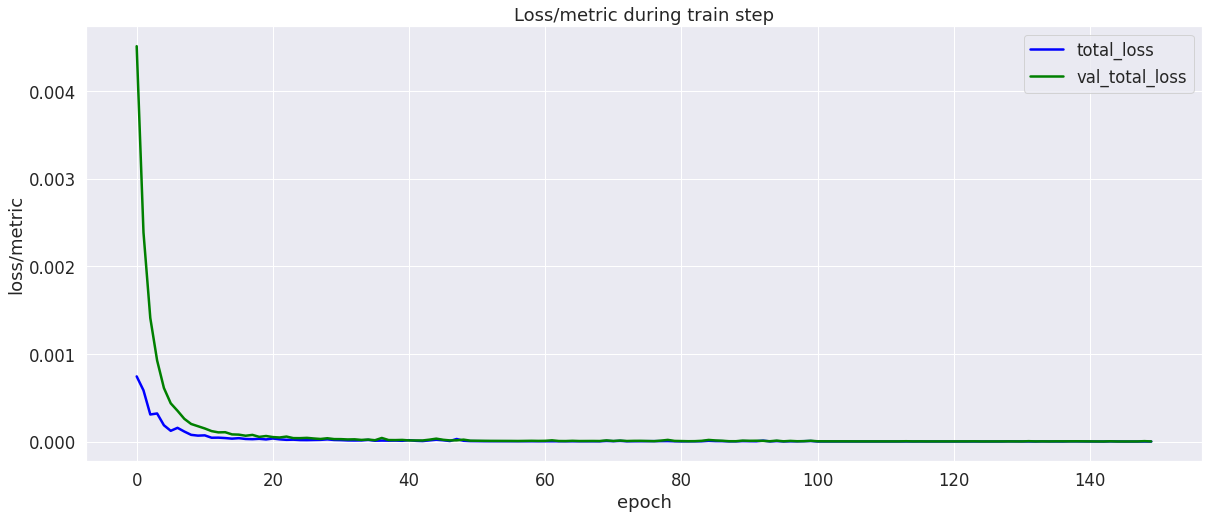

In [18]:
from uad.diagnostic.metrics import plot_history

labels = np.array([["total_loss", "val_total_loss"]])

plot_history(history, metric_names=labels)

In [19]:
predictions = svdd.predict(x_test)
center = np.reshape(svdd.CENTER.numpy(), (1, 32))

In [20]:
print(svdd.score_samples(x_test[:10]) * 10**5)
print(y_test_bin[:10])

[0.07395702 0.16567328 0.08631873 0.07818704 0.04871024 0.08678437
 0.07675123 0.19492425 0.06796109 0.07610772]
[1 1 1 0 1 1 1 1 1 1]


## Plot prediction norms distribution

To adjust the threshold given to is_anormal function



(10000,)


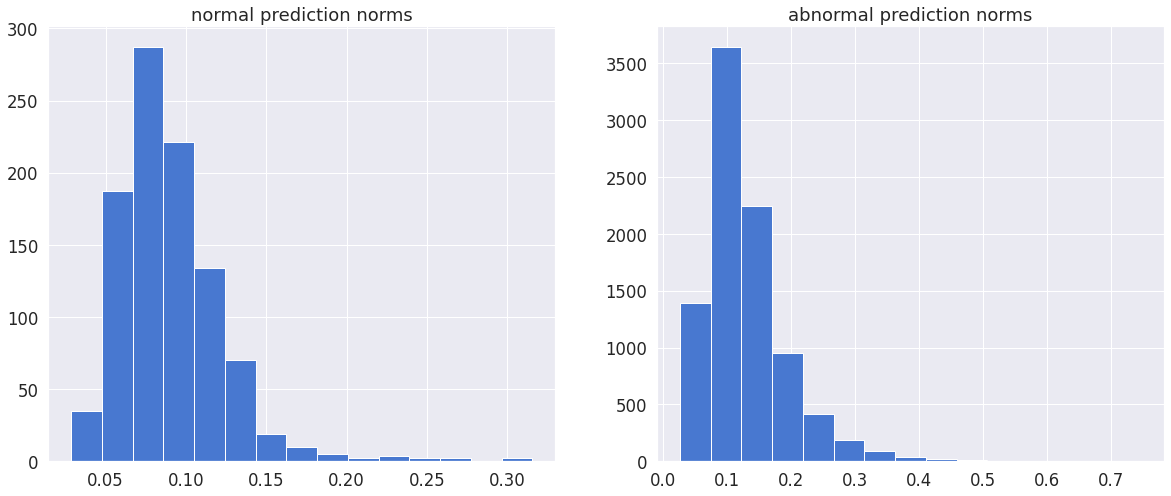

In [21]:
normal_norms, abnormal_norms = [], []

y_scores = svdd.score_samples(x_test)

for score, lab in zip(y_scores, y_test_bin):
    if lab == 0:
        normal_norms.append(score)
    else:
        abnormal_norms.append(score)
        
normal_norms = np.array(normal_norms) * 10**5
abnormal_norms = np.array(abnormal_norms) * 10**5

print(y_scores.shape)

fig, axis = plt.subplots(1, 2, figsize=(20, 8))
for ax, n, title in zip(axis.flatten(), [normal_norms, abnormal_norms], ["normal prediction norms", "abnormal prediction norms"]):
    ax.hist(n, bins=15)
    ax.set_title(title)


## Plot ROC

(<Figure size 504x504 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd128327668>)

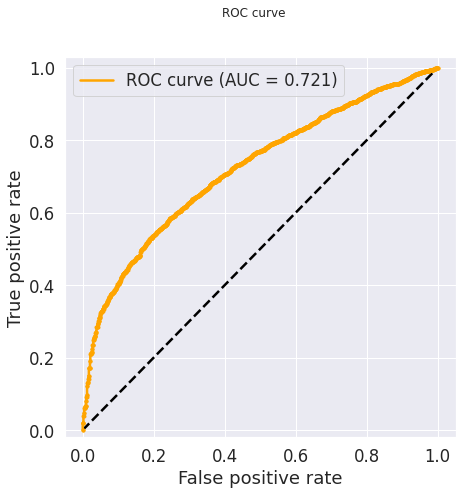

In [22]:
y_scores = svdd.score_samples(x_test)

fprs, tprs, _ = svdd.compute_ROC(y_test_bin, y_scores)

plot_ROC(fprs, tprs)

## t-SNE visualisation

In [23]:
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import time

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def compute_tSNE(dataset, desired_axis=-1):
    """
    Performs tSNE projection on the given dataset, along the desired axis. If a
    third-rank is given, takes the mean of the other axis, to get a final vector
    along the desired axis (since t-SNE only takes vectors as inputs and we don't
    want to mix the different axis)
    :param dataset: np.array
    :param desired_axis: axis on which to project the dataset (e.g. to project
    on channels : axis=-1 in channels_last configuration). None or 0 if you want to
    merge all axis in one.
    :return: an array containing the same number of items than in the given
    dataset but with the output dimension of the t-SNE transformation
    """
    if len(dataset.shape) > 2:  # third-rank tensor or matrix
        if desired_axis is None or desired_axis == 0:
            if len(dataset.shape) == 4:
                batch, x, y, z = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y * z))
            elif len(dataset.shape) == 3:
                batch, x, y = dataset.shape
                dataset = np.reshape(dataset, (batch, x * y))
            elif len(dataset.shape) == 2:  # vectors batch for Deep SVDD
                batch, x = dataset.shape
                dataset = np.reshpae(dataset, (batch, x))
            else:
                raise NotImplementedError(
                    "Input dataset should either be 3 or 2-rank tensor, or batch of vectors with SVDD")
        else:  # merge only non desired axis by taking the mean along each
            axes = range(len(dataset.shape))
            axes = np.delete(axes, desired_axis)
            axes = np.delete(axes, 0)  # keep first axis (individual elements)
            while axes != []:
                dataset = np.mean(dataset, axis=axes[0])  # perform mean along the non-desired axis
                axes = [a - 1 for a in axes]
                del axes[0]
    print(f"t-SNE inputs shape: {dataset.shape}")
    return TSNE().fit_transform(dataset)


def plot_tSNE(dataset, colors, axis=-1, plot_center=None, plt_ax=None):
    """
    Plot the t-SNE projection of a given dataset
    :param dataset: t-SNE outputs
    :param colors: original labels which serve as colors
    :param plot_center: tuple with center coordinates
    :param axis: axis along which to perform t-SNE
    :param plt_ax: matplotlib axis object on which to plot the result
    :return: matplotlib figure, axis, scatter and texts
    """
    if plot_center.any():
        dataset = np.concatenate((dataset, plot_center), axis=0)
        colors = np.concatenate((colors, [-1]), axis=0)

    x = compute_tSNE(dataset, desired_axis=axis)

    print(f"t-SNE output shape: {x.shape}")

    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))
    #     palette = np.array(colors)

    print(num_classes)

    # create a scatter plot.
    if plt_ax is None:
        f = plt.figure(figsize=(8, 8))
        plt_ax = plt.subplot(aspect='equal')
        sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        plt_ax.axis('on')
        plt_ax.axis('tight')
    else:
        f = None
        sc = plt_ax.scatter(x[:, 0], x[:, 1], lw=0, s=40, c=palette[colors.astype(np.int)])
        plt.xlim(-25, 25)
        plt.ylim(-25, 25)
        plt_ax.axis('on')
        plt_ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):
        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = plt_ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, plt_ax, sc, txts


t-SNE inputs shape: (10001, 32)
t-SNE output shape: (10001, 2)
3


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


(<Figure size 576x576 with 1 Axes>,
 [Text(18.42959, 6.2711124, '0'),
  Text(-2.7875671, -1.044027, '1'),
  Text(nan, nan, '2')])

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


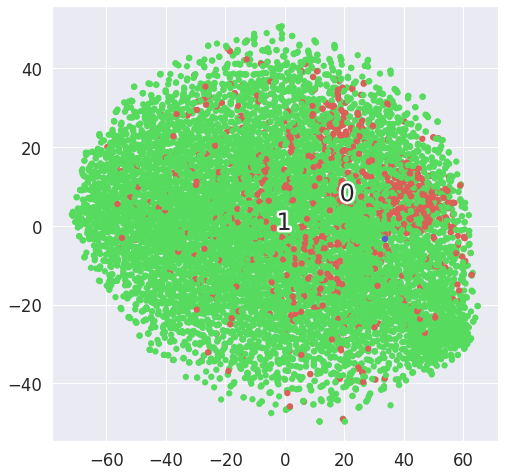

In [24]:
plot_tSNE(predictions, y_test_bin, plot_center=center, axis=0)

On 0: the performances are really poor with this model, because zeros are not well clustered with this technique. This is inconsistent with Ruff results... Wrong implementation??

## Evaluate on all classes (AUC score)

In [25]:
scores = DeepSVDD.evaluate_on_all(r, digits_train, x_test, y_test_bin, n_classes=10, epochs=50, LAMBDA=1e-6, dense_shape=16)

NameError: ignored

In [ ]:
for i, elt in enumerate(scores):
    print(f"Digit: {i}: AUC = {elt}")

Not the same as Ruff 2018